# Прогнозирование с использованием множественной регрессии

## Загрузка данных

In [1]:
import pandas as pd # Работа с табличными данными и рядами
import numpy as np # Работа с массивами
import statsmodels.api as sm # Анализ и построение моделей регрессии
import statsmodels.formula.api as smf # Моделирование с помощью формул

import seaborn as sns # Визуализация
import matplotlib.pyplot as plt # Визуализация

# Графики встраиваются в блокнот:
%matplotlib inline
sns.set() # Стиль графиков

Для обработки табличных данных в Python используется пакет pandas. С тем, как выполнять базовые операции с таблицами и рядами pandas, можно познакомиться по блокнотам в [этом репозитории](https://github.com/postlogist/python-ds/tree/master/pandas).

In [2]:
catalog = pd.read_excel('catalog.xlsx', # файл с данными
                       index_col='date')  # столбец 'date' нужно использовать как индекс

catalog.index.freq='MS' # Уточнили частоту наблюдений - ежемесячно, для индекса используется 1й день месяца.
catalog

,men,women,jewel,mail,page,phone,printadv,service
date,,,,,,,,
1989-01-01,11357.92,16578.93,10776.38,7978,73,34,22294.48,20
1989-02-01,10605.95,18236.13,10821.97,8290,88,29,27426.47,20
1989-03-01,16998.57,43393.55,22845.79,8029,65,24,27978.66,26
1989-04-01,6563.75,30908.49,11102.62,7752,85,20,28949.65,22
1989-05-01,6607.69,28701.58,16066.57,8685,74,17,22642.27,21
...,...,...,...,...,...,...,...,...
1998-08-01,30208.17,58660.76,24377.91,11808,85,44,26668.16,45
1998-09-01,24467.94,57791.14,16044.00,12781,83,49,29911.68,54
1998-10-01,23602.00,56329.40,15974.66,11690,95,43,27872.97,55


Используя встроенные в pandas визуализации, посмотрим на данные. С визуализацией табличных данных в python можно познакомиться в [этом репозитории](https://github.com/postlogist/python-ds/tree/master/EDA)

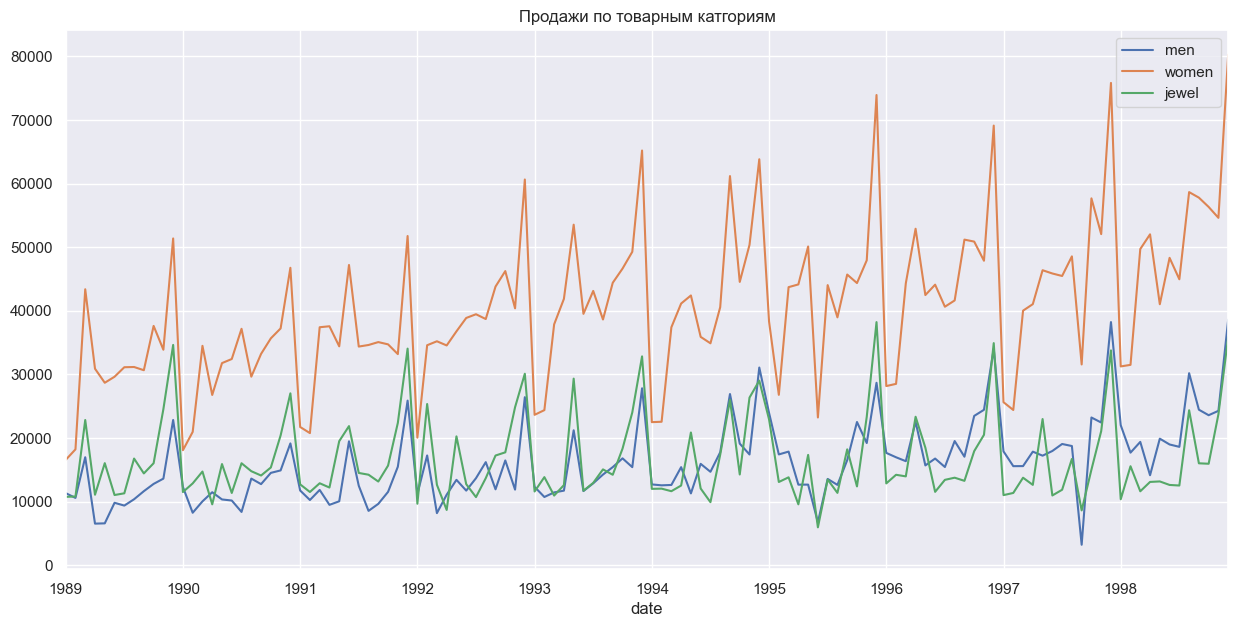

In [3]:
catalog.iloc[:, :3].plot(figsize=(15,7), title='Продажи по товарным катгориям');

На графике виден тренд и сезонность. Тип сезонности - мультипликативный.

## Моделирование

Выберем для анализа только одну товарную категорию - продажи женской одежды


In [4]:
women = catalog[['women', 'mail', 'page', 'phone', 'printadv', 'service']]

Для проверки моделей разделим ряд на два подмножества, используя в качестве тестового множества последний год, а остальные данные - в качестве обучающего множества.

In [5]:
women_train = women[:'1997-12-01'].copy() # Обучающее множество
women_test = women['1998-01-01':].copy() # Тестовое множество

### Разведочный анализ

Для исследования зависимостей в данных можно использовать диаграммы рассеяния. Для анализа зависимостей сразу для всех факторов удобно использовать матричную диаграмму рассеяния.

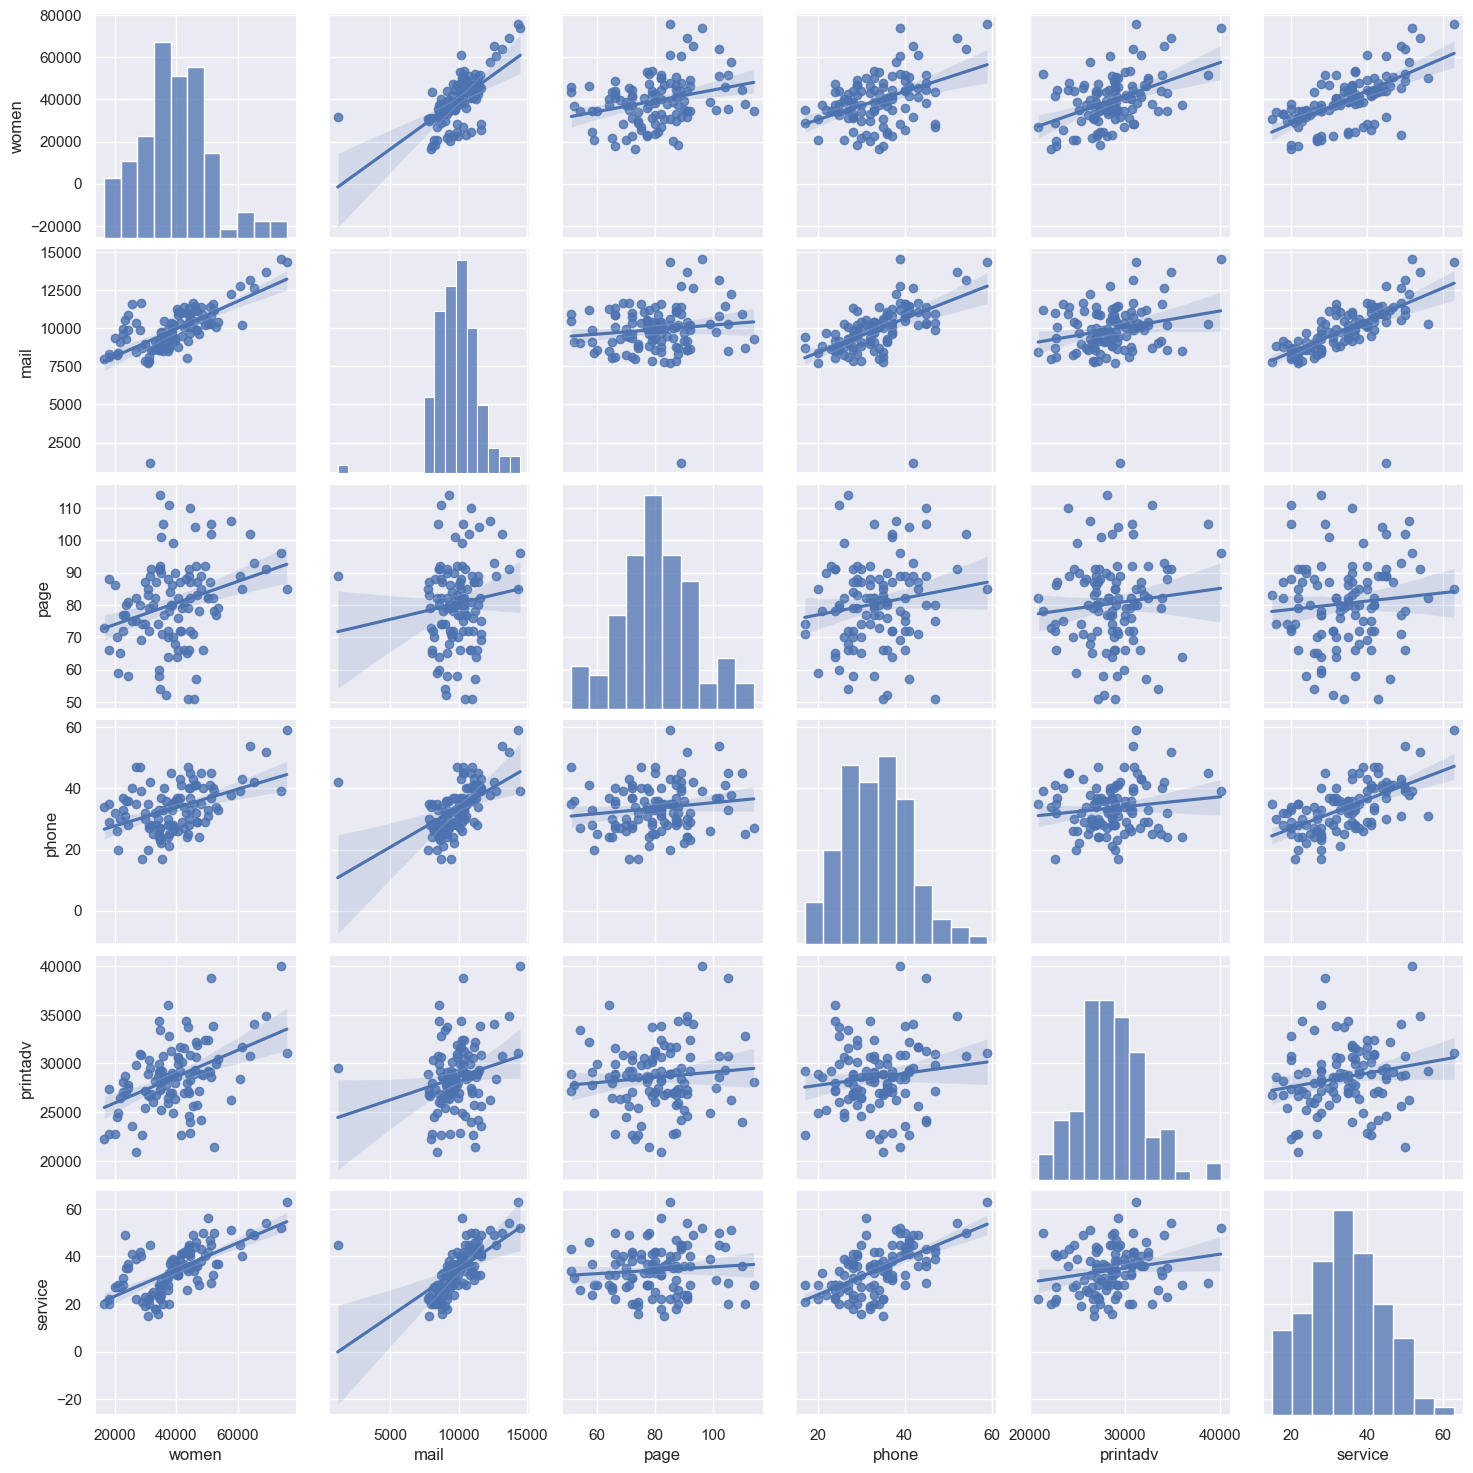

In [6]:
sns.pairplot(women_train, kind='reg');

Для более детального изучения, можно построить отдельные диаграммы рассеяния

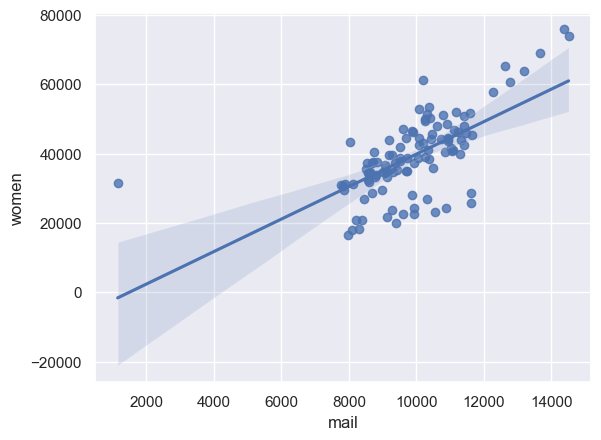

In [7]:
sns.regplot(x='mail', y='women', data=women_train);

Продажи женской одежды коррелированы с количеством разосланных каталогов. Интересно, что точки образуют два облака. Вероятно, зависимость отличается для разных периодов времени.

In [8]:
women_months = women_train[['women', 'mail']].copy() # Сделаем отдельную таблицу для проверки гипотезы
women_months['month'] = women.index.to_series().dt.month # Выделяем месяц из даты в индексе
women_months.head()

,women,mail,month
date,,,
1989-01-01,16578.93,7978,1
1989-02-01,18236.13,8290,2
1989-03-01,43393.55,8029,3
1989-04-01,30908.49,7752,4
1989-05-01,28701.58,8685,5


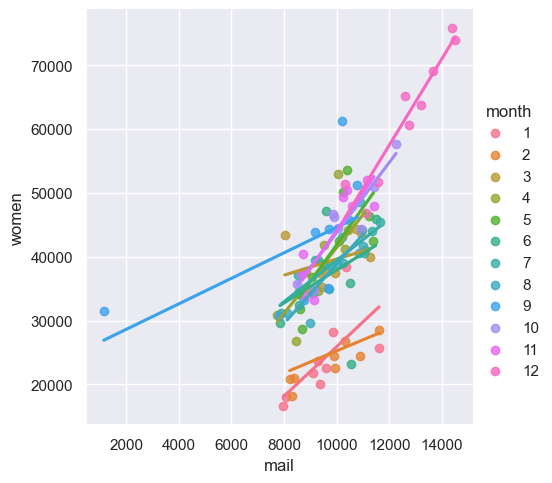

In [9]:
sns.lmplot(x='mail', y='women', data=women_months, hue='month', ci=None);

Действительно, продажи в январе и феврале отличаются по характеру от остальных.

Количественную оценку тесноты и направления зависимости можно получить при помощи коэффициентов корреляции.

In [10]:
women_corr = women_train.corr().round(2)
women_corr

,women,mail,page,phone,printadv,service
women,1.00,0.65,0.29,0.45,0.46,0.66
mail,0.65,1.00,0.12,0.54,0.22,0.64
page,0.29,0.12,1.00,0.15,0.11,0.10
phone,0.45,0.54,0.15,1.00,0.14,0.60
printadv,0.46,0.22,0.11,0.14,1.00,0.20
service,0.66,0.64,0.10,0.60,0.20,1.00


Визуализация матрицы корреляций

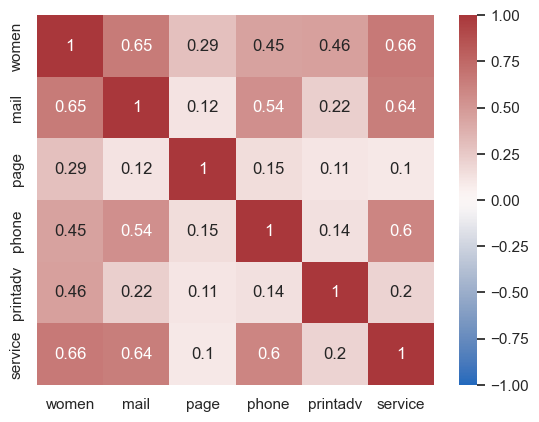

In [11]:
colormap = sns.color_palette('vlag', as_cmap=True)
sns.heatmap(women_corr, cmap=colormap, annot=True, vmin=-1, vmax=1);

Наиболее коррелированные с продажами факторы - mail и service.

### Модель линейной регрессии

Для начала рассмотрим модель с одним предиктором - mail, который наиболее коррелирован с целевой переменной.

Аргументом метода `.ols()` является формула вида `y ~ x1 + x2 +...`, которая задает спецификацию модели. Про использование формул можно почитать здесь: https://www.statsmodels.org/devel/examples/notebooks/generated/formulas.html и здесь: https://patsy.readthedocs.io/en/latest/formulas.html#the-formula-language

In [12]:
women_m_mail = smf.ols('women ~ mail', data=women_train).fit()
women_m_mail.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  women   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     78.39
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           2.12e-14
Time:                        23:16:09   Log-Likelihood:                -1133.8
No. Observations:                 108   AIC:                             2272.
Df Residuals:                     106   BIC:                             2277.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6968.9287   5314.752     -1.311      0.193   -1.75e+04    3568.084
mail           4.6840      0.529      8.854      0.000       3.635       5.733
==============================================================================
Omnibus:                        5.754   Durbin-Watson:                   1.532
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                9.034
Skew:                           0.005   Prob(JB):                       0.0109
Kurtosis:                       4.417   Cond. No.                     6.26e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Коэффициенты модели:

In [13]:
women_m_mail.params

Intercept   -6968.928689
mail            4.683972
dtype: float64

Для получения прогноза подставим значения mail из тестовой выборки:

In [14]:
women_f_mail = women_m_mail.predict(women_test)

In [15]:
women_f_mail

date
1998-01-01    48723.500615
1998-02-01    47936.593288
1998-03-01    47313.624987
1998-04-01    47519.719763
1998-05-01    49009.222919
1998-06-01    47861.649733
1998-07-01    46709.392575
1998-08-01    48339.414896
1998-09-01    52896.919834
1998-10-01    47786.706178
1998-11-01    46395.566438
1998-12-01    64522.538802
dtype: float64

Получен ряд с прогнозом. Сравним его с фактом.

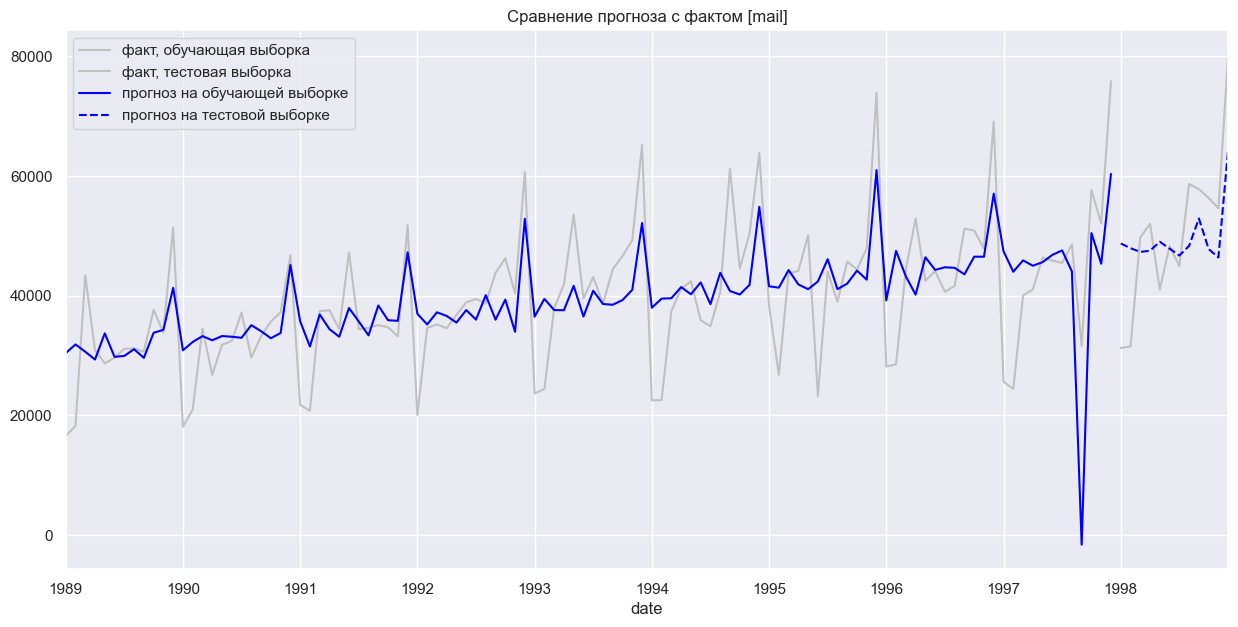

In [16]:
plt.subplots(figsize=(15, 7))
women_train['women'].plot(color='silver', label='факт, обучающая выборка')
women_test['women'].plot(color='silver', label='факт, тестовая выборка')
women_m_mail.fittedvalues.plot(color='blue', label='прогноз на обучающей выборке')
women_f_mail.plot(color='blue', label='прогноз на тестовой выборке', linestyle='dashed')
plt.title('Сравнение прогноза с фактом [mail]')
plt.legend();

Рассчитаем показатели ошибки прогноза

In [17]:
# Подготовка функций для расчета показателей ошибки
from statsmodels.tools.eval_measures import rmse, bias, meanabs

mape = lambda actuals, forecast : ((actuals - forecast).abs() / actuals).mean()

def metrics(model, actuals, forecast):
    return pd.DataFrame({'model' : model, 
                         'mape' : mape(actuals, forecast),
                         'rmse' : rmse(actuals, forecast),
                         'bias' : bias(actuals, forecast)
                        }, index = [1])

In [18]:
women_metrics = metrics('Лин. регрессия, mail', women_test['women'], women_f_mail)
women_metrics

,model,mape,rmse,bias
1,"Лин. регрессия, mail",0.184651,9939.606066,956.953331


### Модель с двумя предикторами

Чтобы улучшить качество модели, попробуем добавить в нее другие предикторы. Для выбора следующего предиктора, рассчитаем корреляцию оставшихся переменных с остатками первой модели.

In [19]:
women_train['err1'] = women_m_mail.resid
women_corr1 = women_train.loc[:, ~women_train.columns.isin(['women', 'mail'])].corr()
women_corr1.round(2)

,page,phone,printadv,service,err1
page,1.00,0.15,0.11,0.10,0.28
phone,0.15,1.00,0.14,0.60,0.13
printadv,0.11,0.14,1.00,0.20,0.42
service,0.10,0.60,0.20,1.00,0.32
err1,0.28,0.13,0.42,0.32,1.00


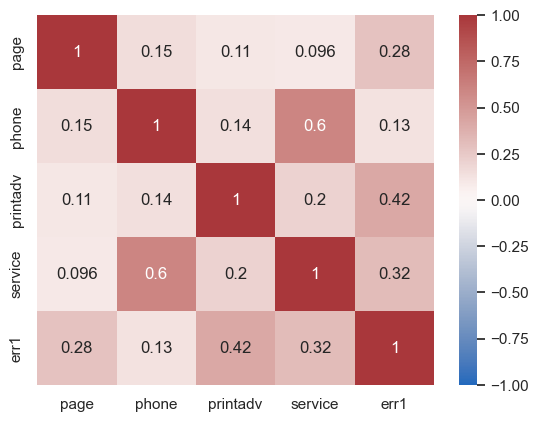

In [20]:
sns.heatmap(women_corr1, cmap=colormap, annot=True, vmin=-1, vmax=1);

Наибольшую корреляцию с остатками первой модели имеет переменная printadv.

In [21]:
women_m_printadv = smf.ols('women ~ mail + printadv', data=women_train).fit()
women_m_printadv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  women   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     59.54
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           5.21e-18
Time:                        23:16:09   Log-Likelihood:                -1122.8
No. Observations:                 108   AIC:                             2252.
Df Residuals:                     105   BIC:                             2260.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.435e+04   7398.307     -4.643      0.000    -4.9e+04   -1.97e+04
mail           4.1443      0.492      8.415      0.000       3.168       5.121
printadv       1.1450      0.235      4.880      0.000       0.680       1.610
==============================================================================
Omnibus:                        3.944   Durbin-Watson:                   1.325
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                4.641
Skew:                          -0.084   Prob(JB):                       0.0982
Kurtosis:                       4.002   Cond. No.                     2.91e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.91e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Получим и сравним прогноз

In [22]:
women_f_printadv = women_m_printadv.predict(women_test)

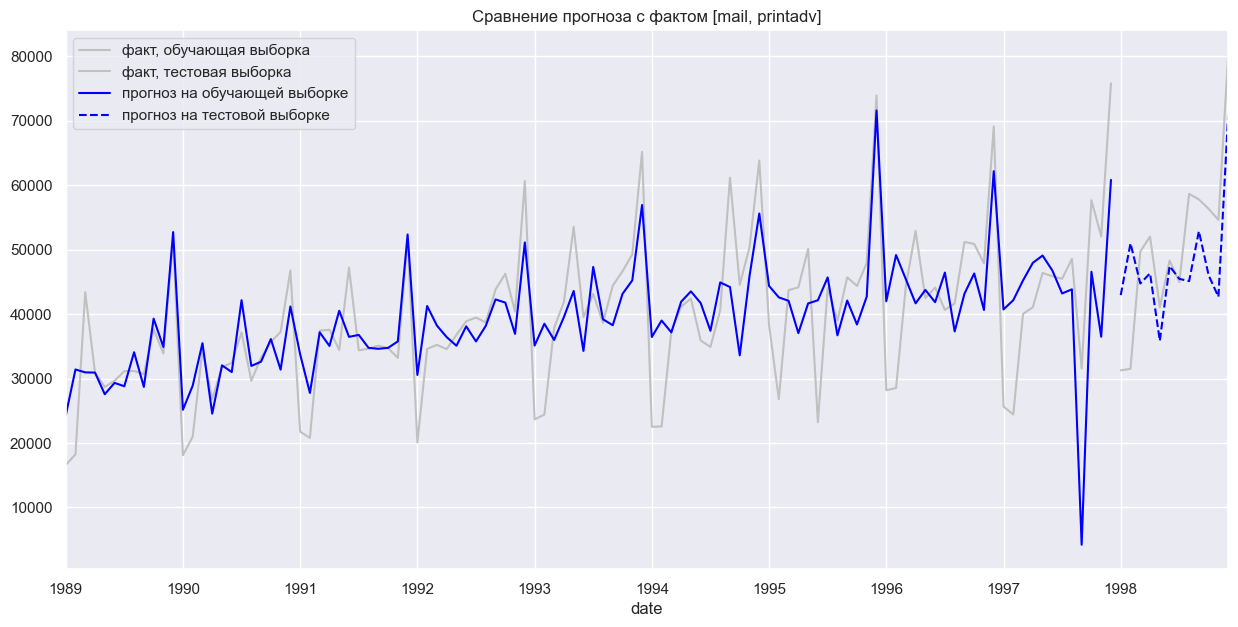

In [23]:
plt.subplots(figsize=(15, 7))
women_train['women'].plot(color='silver', label='факт, обучающая выборка')
women_test['women'].plot(color='silver', label='факт, тестовая выборка')
women_m_printadv.fittedvalues.plot(color='blue', label='прогноз на обучающей выборке')
women_f_printadv.plot(color='blue', label='прогноз на тестовой выборке', linestyle='dashed')
plt.title('Сравнение прогноза с фактом [mail, printadv]')
plt.legend();

In [24]:
women_metrics = pd.concat([
    women_metrics,
    metrics('Лин. регрессия, mail + printadv', women_test['women'], women_f_printadv)
])

women_metrics.sort_values(by='mape')

,model,mape,rmse,bias
1,"Лин. регрессия, mail + printadv",0.182589,9767.242387,2929.484647
1,"Лин. регрессия, mail",0.184651,9939.606066,956.953331


Качество прогноза незначительно улучшилось.

### Модель с тремя предикторами

Попробуем включить еще один предиктор.

In [25]:
women_train['err2'] = women_m_printadv.resid
women_corr2 = women_train.loc[:, ~women_train.columns.isin(['women', 'mail', 'printadv', 'err1'])].corr()
women_corr2.round(2)

,page,phone,service,err2
page,1.00,0.15,0.10,0.27
phone,0.15,1.00,0.60,0.13
service,0.10,0.60,1.00,0.32
err2,0.27,0.13,0.32,1.00


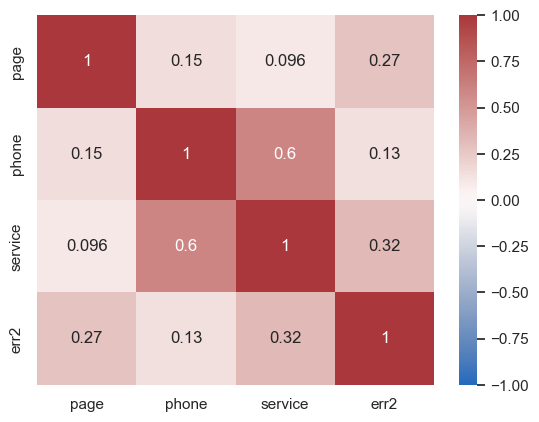

In [26]:
sns.heatmap(women_corr2, cmap=colormap, annot=True, vmin=-1, vmax=1);

Наибольшую корреляцию с ошибками второй модели имеет предиктор service.

In [27]:
women_m_service = smf.ols('women ~ mail + printadv + service', data=women_train).fit()
women_m_service.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  women   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     55.59
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           1.59e-21
Time:                        23:16:10   Log-Likelihood:                -1112.1
No. Observations:                 108   AIC:                             2232.
Df Residuals:                     104   BIC:                             2243.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.034e+04   6782.062     -4.474      0.000   -4.38e+04   -1.69e+04
mail           2.4238      0.574      4.219      0.000       1.285       3.563
printadv       1.0637      0.214      4.968      0.000       0.639       1.488
service      449.1235     93.876      4.784      0.000     262.964     635.283
==============================================================================
Omnibus:                       19.012   Durbin-Watson:                   1.397
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.474
Skew:                          -0.960   Prob(JB):                     7.99e-06
Kurtosis:                       4.237   Cond. No.                     2.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Получим и сравним прогноз

In [28]:
women_f_service = women_m_service.predict(women_test)

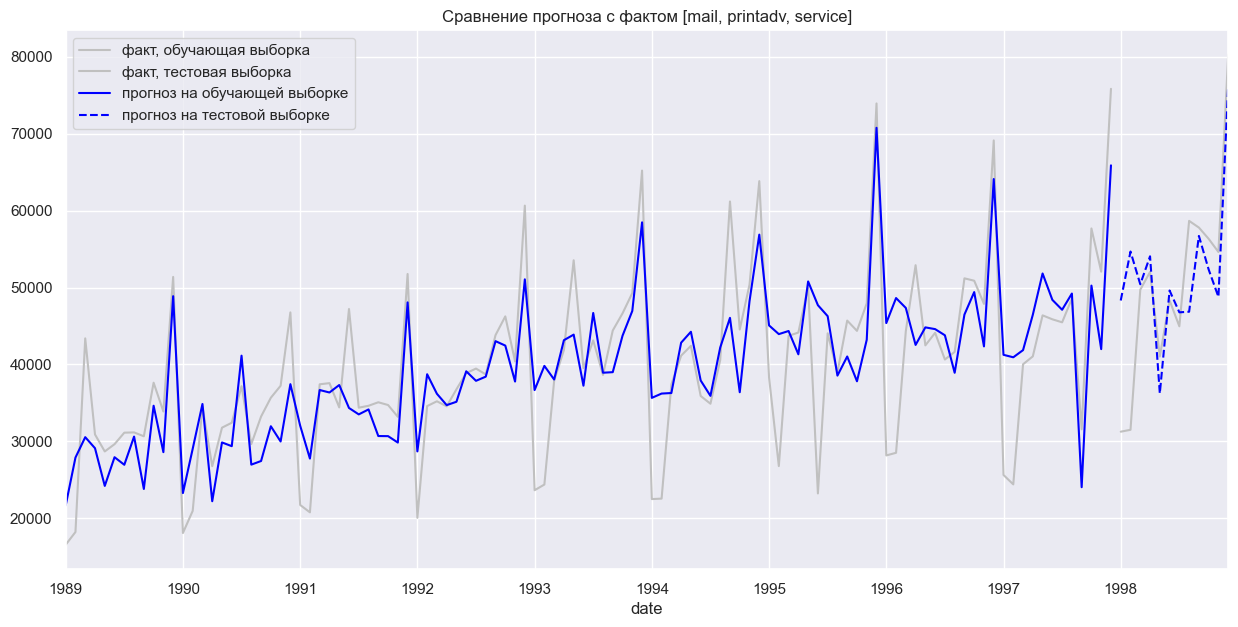

In [29]:
plt.subplots(figsize=(15, 7))
women_train['women'].plot(color='silver', label='факт, обучающая выборка')
women_test['women'].plot(color='silver', label='факт, тестовая выборка')
women_m_service.fittedvalues.plot(color='blue', label='прогноз на обучающей выборке')
women_f_service.plot(color='blue', label='прогноз на тестовой выборке', linestyle='dashed')
plt.title('Сравнение прогноза с фактом [mail, printadv, service]')
plt.legend();

In [30]:
women_metrics = pd.concat([
    women_metrics,
    metrics('Лин. регрессия, mail + printadv + service', 
                                             women_test['women'], women_f_service)
])
women_metrics.sort_values(by='mape')

,model,mape,rmse,bias
1,"Лин. регрессия, mail + printadv + service",0.163765,9427.154547,-1208.551038
1,"Лин. регрессия, mail + printadv",0.182589,9767.242387,2929.484647
1,"Лин. регрессия, mail",0.184651,9939.606066,956.953331


### Модель с четырьмя предикторами

In [31]:
women_train['err3'] = women_m_service.resid
women_corr3 = women_train.loc[:, ~women_train.columns.isin(['women', 'mail', 'printadv', 'service', 'err1', 'err2'])].corr()
women_corr3.round(2)

,page,phone,err3
page,1.00,0.15,0.29
phone,0.15,1.00,-0.01
err3,0.29,-0.01,1.00


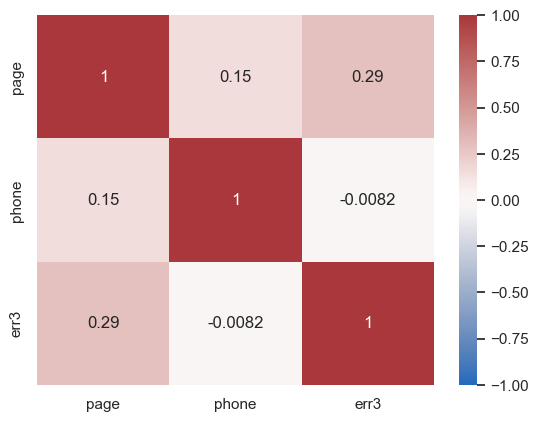

In [32]:
sns.heatmap(women_corr3, cmap=colormap, annot=True, vmin=-1, vmax=1);

Небольшую корреляцию с остатками имеет предиктор page, попробуем его включить.

In [33]:
women_m_page = smf.ols('women ~ mail + printadv + service + page', data=women_train).fit()
women_m_page.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  women   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     47.82
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           1.14e-22
Time:                        23:16:11   Log-Likelihood:                -1107.1
No. Observations:                 108   AIC:                             2224.
Df Residuals:                     103   BIC:                             2238.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.068e+04   7279.633     -5.588      0.000   -5.51e+04   -2.62e+04
mail           2.3042      0.552      4.172      0.000       1.209       3.400
printadv       1.0120      0.206      4.912      0.000       0.603       1.421
service      444.3555     90.064      4.934      0.000     265.736     622.975
page         163.7100     51.713      3.166      0.002      61.149     266.271
==============================================================================
Omnibus:                       17.636   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.115
Skew:                          -0.873   Prob(JB):                     1.58e-05
Kurtosis:                       4.366   Cond. No.                     3.29e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
women_f_page = women_m_page.predict(women_test)

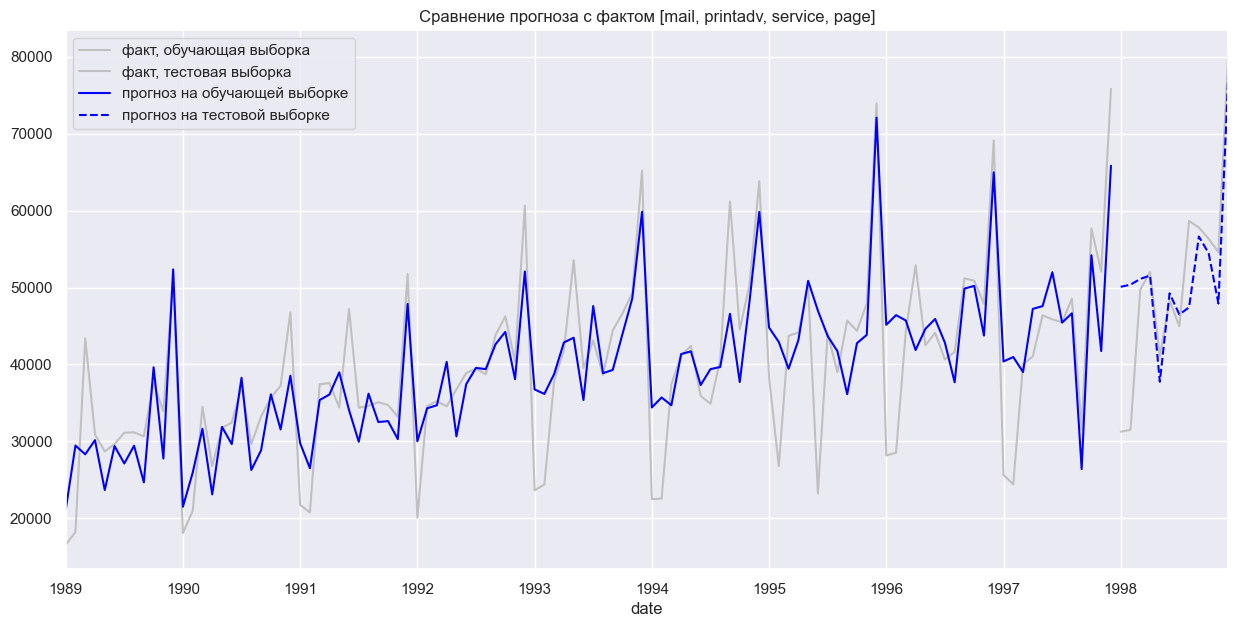

In [35]:
plt.subplots(figsize=(15, 7))
women_train['women'].plot(color='silver', label='факт, обучающая выборка')
women_test['women'].plot(color='silver', label='факт, тестовая выборка')
women_m_page.fittedvalues.plot(color='blue', label='прогноз на обучающей выборке')
women_f_page.plot(color='blue', label='прогноз на тестовой выборке', linestyle='dashed')
plt.title('Сравнение прогноза с фактом [mail, printadv, service, page]')
plt.legend();

In [36]:
women_metrics = pd.concat([
    women_metrics,
    metrics('Лин. регрессия, mail + printadv + service + page', 
                                             women_test['women'], women_f_page)
])

women_metrics.sort_values(by='mape')

,model,mape,rmse,bias
1,"Лин. регрессия, mail + printadv + service + page",0.147869,8710.000257,-1161.812350
1,"Лин. регрессия, mail + printadv + service",0.163765,9427.154547,-1208.551038
1,"Лин. регрессия, mail + printadv",0.182589,9767.242387,2929.484647
1,"Лин. регрессия, mail",0.184651,9939.606066,956.953331


Больше не осталось предикторов, коррелированных с остатками.

### Сезонная регрессия

Модель линейной регрессии можно применять даже когда нет внешних предикторов. Временной ряд моделировать как линейный тренд и набор сезонных коэффициенто. Эти значения можно получить из данных временного ряда и индекса дат.

In [37]:
women_s = women[['women']].copy()
women_s.head()

,women
date,
1989-01-01,16578.93
1989-02-01,18236.13
1989-03-01,43393.55
1989-04-01,30908.49
1989-05-01,28701.58


Добавим номера периодов

In [38]:
women_s['period'] = np.arange(1, len(women_s) + 1)
women_s

,women,period
date,,
1989-01-01,16578.93,1
1989-02-01,18236.13,2
1989-03-01,43393.55,3
1989-04-01,30908.49,4
1989-05-01,28701.58,5
...,...,...
1998-08-01,58660.76,116
1998-09-01,57791.14,117
1998-10-01,56329.40,118


Добавим месяцы

In [39]:
women_s['month'] = women_s.index.to_series().dt.month
women_s

,women,period,month
date,,,
1989-01-01,16578.93,1,1
1989-02-01,18236.13,2,2
1989-03-01,43393.55,3,3
1989-04-01,30908.49,4,4
1989-05-01,28701.58,5,5
...,...,...,...
1998-08-01,58660.76,116,8
1998-09-01,57791.14,117,9
1998-10-01,56329.40,118,10


Подготовим обучающую и тестовую выборку:

In [40]:
women_s_train = women_s[:'1997-12-01'].copy() # Обучающее множество
women_s_test = women_s['1998-01-01':].copy() # Тестовое множество

Месяц - категориальная переменная, ее необходимо преобразовать в набор фиктивных переменных. Эту задачу может автоматически решить statsmodels, если использовать `C()` в формуле (https://www.statsmodels.org/devel/examples/notebooks/generated/contrasts.html)

In [41]:
women_m_seasonal = smf.ols('women ~ period + C(month)', data=women_s_train).fit()
women_m_seasonal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  women   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     32.19
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           3.13e-28
Time:                        23:16:11   Log-Likelihood:                -1076.1
No. Observations:                 108   AIC:                             2178.
Df Residuals:                      95   BIC:                             2213.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.649e+04   2008.798      8.207      0.000    1.25e+04    2.05e+04
C(month)[T.2]    569.2372   2584.352      0.220      0.826   -4561.351    5699.825
C(month)[T.3]   1.515e+04   2584.521      5.863      0.000       1e+04    2.03e+04
C(month)[T.4]   1.467e+04   2584.801      5.677      0.000    9542.346    1.98e+04
C(month)[T.5]   1.626e+04   2585.194      6.291      0.000    1.11e+04    2.14e+04
C(month)[T.6]    1.28e+04   2585.698      4.951      0.000    7668.655    1.79e+04
C(month)[T.7]   1.416e+04   2586.315      5.473      0.000    9021.389    1.93e+04
C(month)[T.8]   1.314e+04   2587.043      5.079      0.000    8002.609    1.83e+04
C(month)[T.9]    1.68e+04   2587.883      6.491      0.000    1.17e+04    2.19e+04
C(month)[T.10]  1.904e+04   2588.835      7.355      0.000    1.39e+04    2.42e+04
C(month)[T.11]  1.821e+04   2589.899      7.030      0.000    1.31e+04    2.33e+04
C(month)[T.12]  3.652e+04   2591.073     14.093      0.000    3.14e+04    4.17e+04
period           150.7184     17.026      8.852      0.000     116.918     184.518
==============================================================================
Omnibus:                       12.417   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               37.032
Skew:                           0.123   Prob(JB):                     9.09e-09
Kurtosis:                       5.858   Cond. No.                         782.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
women_f_seasonal = women_m_seasonal.predict(women_s_test)

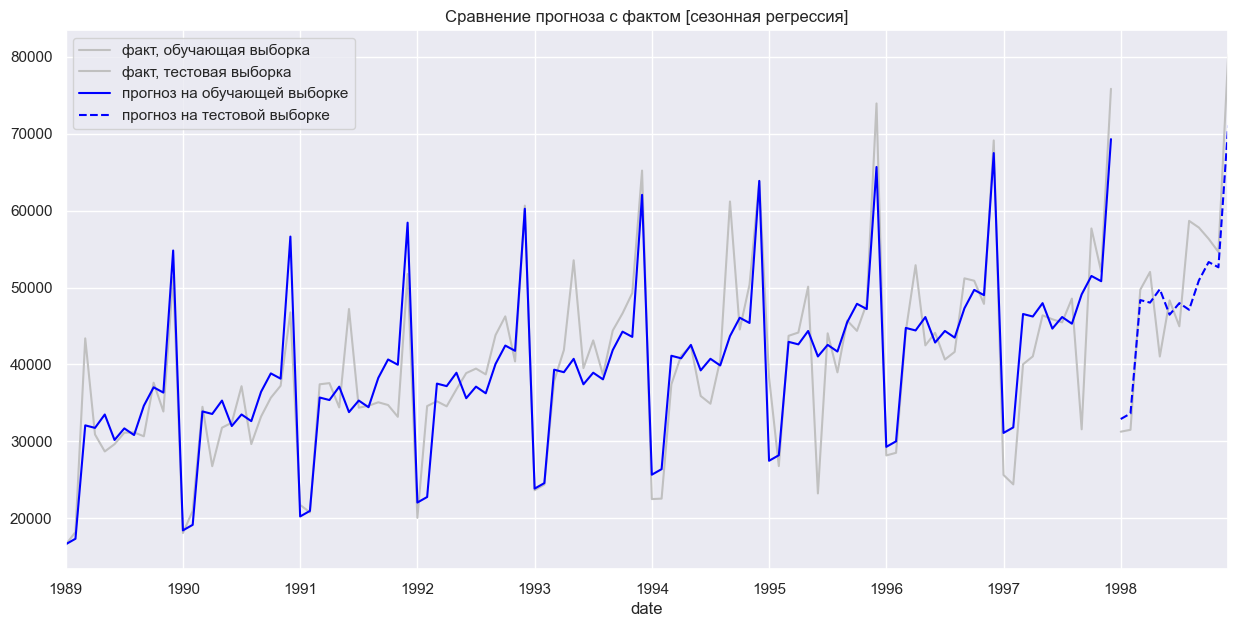

In [43]:
plt.subplots(figsize=(15, 7))
women_train['women'].plot(color='silver', label='факт, обучающая выборка')
women_test['women'].plot(color='silver', label='факт, тестовая выборка')
women_m_seasonal.fittedvalues.plot(color='blue', label='прогноз на обучающей выборке')
women_f_seasonal.plot(color='blue', label='прогноз на тестовой выборке', linestyle='dashed')
plt.title('Сравнение прогноза с фактом [сезонная регрессия]')
plt.legend();

In [44]:
women_metrics = pd.concat([
    women_metrics,
    metrics('Сезонная регрессия', 
                                             women_s_test['women'], women_f_seasonal)
])

women_metrics.sort_values(by='mape')

,model,mape,rmse,bias
1,Сезонная регрессия,0.088504,5711.236041,2021.168125
1,"Лин. регрессия, mail + printadv + service + page",0.147869,8710.000257,-1161.812350
1,"Лин. регрессия, mail + printadv + service",0.163765,9427.154547,-1208.551038
1,"Лин. регрессия, mail + printadv",0.182589,9767.242387,2929.484647
1,"Лин. регрессия, mail",0.184651,9939.606066,956.953331


В данном примере сезонная регрессия оказалась лучшей моделью, хотя она не учитывает некоторые пики и спады продаж, которые были объяснены моделями с внешними предикторами. Возможно, сочетание обоих подходов позволит еще улучшить точность прогноза.

### Полиномиальный тренд

Сезонная регрессия основана на линейном тренде, поэтому при ее использовании необходимо отбирать такой обучающий период, где тренд линеен. Дополнительно можно попробовать смоделировать полиномиальный тренд, включив квадрат номера периода (см. https://stackoverflow.com/questions/31978948/python-stats-models-quadratic-term-in-regression). Можно попробовать включать степени и более высокого порядка, но поведение модели может быстро стать нестабильным. 

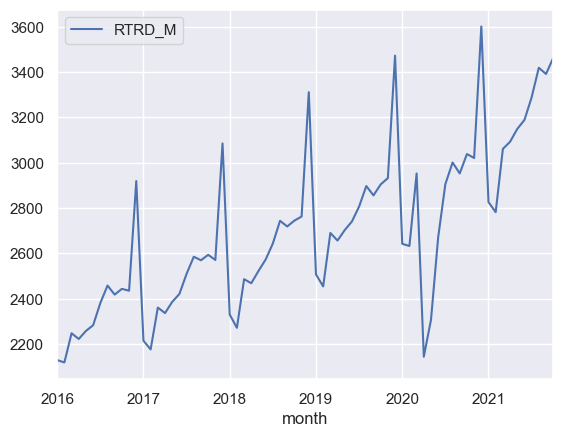

In [45]:
retail = pd.read_excel('retail.xlsx', # файл с данными
                       index_col='month'  # столбец 'month' нужно использовать как индекс                       
                      ) 

retail.index.freq='MS' # Уточнили частоту наблюдений - ежемесячно, для индекса используется 1й день месяца.
retail = retail.loc['2016-01-01':]
retail.plot();

In [46]:
retail['period'] = np.arange(1, len(retail) + 1)
retail

,RTRD_M,period
month,,
2016-01-01,2129.5,1
2016-02-01,2119.0,2
2016-03-01,2247.8,3
2016-04-01,2222.6,4
2016-05-01,2258.1,5
...,...,...
2021-06-01,3189.0,66
2021-07-01,3288.8,67
2021-08-01,3419.4,68


In [47]:
retail['month'] = retail.index.to_series().dt.month
retail

,RTRD_M,period,month
month,,,
2016-01-01,2129.5,1,1
2016-02-01,2119.0,2,2
2016-03-01,2247.8,3,3
2016-04-01,2222.6,4,4
2016-05-01,2258.1,5,5
...,...,...,...
2021-06-01,3189.0,66,6
2021-07-01,3288.8,67,7
2021-08-01,3419.4,68,8


In [48]:
retail_train = retail[:'2020-09-01'].copy() # Обучающее множество
retail_test = retail['2020-10-01':].copy() # Тестовое множество

In [49]:
retail_m_linear = smf.ols('RTRD_M ~ period + C(month)', data=retail_train).fit()
retail_m_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RTRD_M   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     27.24
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           1.90e-16
Time:                        23:16:12   Log-Likelihood:                -343.40
No. Observations:                  57   AIC:                             712.8
Df Residuals:                      44   BIC:                             739.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2113.1673     55.940     37.775      0.000    2000.427    2225.907
C(month)[T.2]    -44.0517     72.024     -0.612      0.544    -189.207     101.104
C(month)[T.3]    162.6966     72.042      2.258      0.029      17.505     307.888
C(month)[T.4]    -29.3151     72.072     -0.407      0.686    -174.566     115.936
C(month)[T.5]     30.1932     72.113      0.419      0.677    -115.142     175.528
C(month)[T.6]    122.7815     72.167      1.701      0.096     -22.662     268.224
C(month)[T.7]    224.2298     72.232      3.104      0.003      78.655     369.804
C(month)[T.8]    301.8781     72.309      4.175      0.000     156.148     447.608
C(month)[T.9]    257.8463     72.398      3.561      0.001     111.937     403.756
C(month)[T.10]   276.6499     76.437      3.619      0.001     122.600     430.699
C(month)[T.11]   270.2532     76.477      3.534      0.001     116.125     424.382
C(month)[T.12]   782.1315     76.527     10.220      0.000     627.901     936.362
period            10.0717      0.926     10.876      0.000       8.205      11.938
==============================================================================
Omnibus:                       49.734   Durbin-Watson:                   1.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.290
Skew:                          -2.361   Prob(JB):                     1.09e-52
Kurtosis:                      11.858   Cond. No.                         406.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
retail_m_quadratic = smf.ols('RTRD_M ~ period + np.power(period, 2) + C(month)', data=retail_train).fit()
retail_m_quadratic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RTRD_M   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     25.60
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           4.82e-16
Time:                        23:16:12   Log-Likelihood:                -342.37
No. Observations:                  57   AIC:                             712.7
Df Residuals:                      43   BIC:                             741.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2070.5074     65.091     31.810      0.000    1939.239    2201.775
C(month)[T.2]         -44.6078     71.552     -0.623      0.536    -188.906      99.690
C(month)[T.3]         161.7433     71.572      2.260      0.029      17.404     306.083
C(month)[T.4]         -30.5067     71.604     -0.426      0.672    -174.910     113.897
C(month)[T.5]          28.9221     71.646      0.404      0.688    -115.566     173.411
C(month)[T.6]         121.5899     71.699      1.696      0.097     -23.004     266.184
C(month)[T.7]         223.2765     71.761      3.111      0.003      78.556     367.997
C(month)[T.8]         301.3220     71.835      4.195      0.000     156.452     446.191
C(month)[T.9]         257.8463     71.922      3.585      0.001     112.801     402.891
C(month)[T.10]        266.8786     76.330      3.496      0.001     112.944     420.814
C(month)[T.11]        260.4025     76.376      3.409      0.001     106.376     414.429
C(month)[T.12]        772.3602     76.419     10.107      0.000     618.246     926.474
period                 14.6793      3.774      3.889      0.000       7.068      22.291
np.power(period, 2)    -0.0794      0.063     -1.259      0.215      -0.207       0.048
==============================================================================
Omnibus:                       44.059   Durbin-Watson:                   1.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.776
Skew:                          -2.096   Prob(JB):                     9.16e-40
Kurtosis:                      10.624   Cond. No.                     1.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
retail_f_linear = retail_m_linear.predict(retail_test)
retail_f_quadratic = retail_m_quadratic.predict(retail_test)

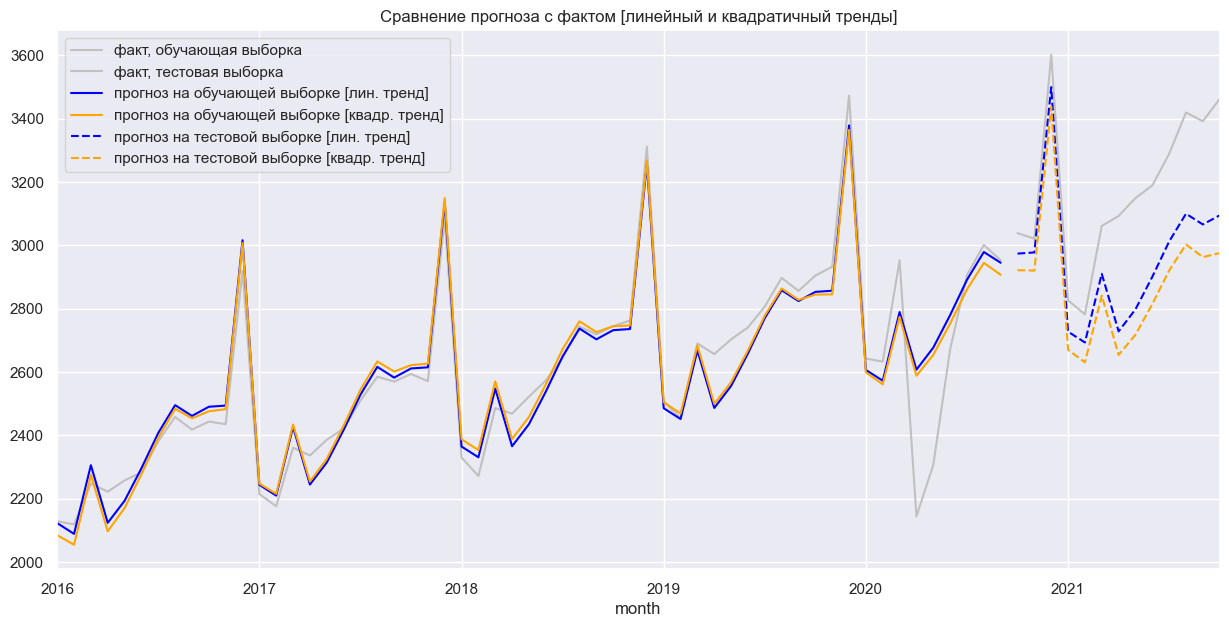

In [52]:
plt.subplots(figsize=(15, 7))
retail_train['RTRD_M'].plot(color='silver', label='факт, обучающая выборка')
retail_test['RTRD_M'].plot(color='silver', label='факт, тестовая выборка')
retail_m_linear.fittedvalues.plot(color='blue', label='прогноз на обучающей выборке [лин. тренд]')
retail_m_quadratic.fittedvalues.plot(color='orange', label='прогноз на обучающей выборке [квадр. тренд]')
retail_f_linear.plot(color='blue', label='прогноз на тестовой выборке [лин. тренд]', linestyle='dashed')
retail_f_quadratic.plot(color='orange', label='прогноз на тестовой выборке [квадр. тренд]', linestyle='dashed')
plt.title('Сравнение прогноза с фактом [линейный и квадратичный тренды]')
plt.legend();

In [53]:
retail_metrics = pd.concat([
   metrics('Сезонная регрессия, лин. тренд', retail_test['RTRD_M'], retail_f_linear),
   metrics('Сезонная регрессия, квадр. тренд', retail_test['RTRD_M'], retail_f_quadratic) 
])

retail_metrics.sort_values(by='mape')

,model,mape,rmse,bias
1,"Сезонная регрессия, лин. тренд",0.067673,250.557584,218.640147
1,"Сезонная регрессия, квадр. тренд",0.091986,327.560252,296.443619


В данном случае метод себя не оправдал. Заметим, что при использовании нелинейных трендов также следует тщательно выбирать необходимую глубину исторического периода.